Hola **Arturo**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Te felicito por incluir esta sección introductoria ya que ayuda a entender el que y cómo de tu proyecto antes de revisar cada celda, te animo a mantener esta buena práctica!
</div>

## Preparación

In [1]:
pip install CatBoost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install LightGBM

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

<div class="alert alert-block alert-info">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Una buena práctica para cuando tengas que importar varias librerías es seguir el siguiente órden en las mismas:

- Primero todas las librerías que vienen ya con python cómo `datetime`, `os`, `json`, etc.
- Luego de las librerías de Python si las de terceros cómo `pandas`, `scipy`, `numpy`, etc.
- Por último, en el caso de que armes tu propio módulo en tu proyecto esto debería ir en tercer lugar, y recuerda siempre ordenar cada tipo por orden alfabético
    
Para cada sección se deben ordenar en orden alfabético
</div>

In [4]:
#Cargamos la data, indicamos que la primera columna con las fechas sea el índice con "index_col" y combertimos la data a tipo datetime con "parse_dates"
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(df.info())
print()
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


La información de nuetsro dataframe está muestreada por cada 10 minutos.
Nosotros neceistamos tener esta información por hora, es necesario ajustar los intervalos de muestreo para trabajar con nuestra data.

In [5]:
#Aquí vamos a resamplear los datos para que trabajar con ellos usando intervalos de 1 hora.
df.sort_index(inplace=True)
df = df.resample('1H').sum()

print(df.head(24))

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
2018-03-01 05:00:00           6
2018-03-01 06:00:00          12
2018-03-01 07:00:00          15
2018-03-01 08:00:00          34
2018-03-01 09:00:00          69
2018-03-01 10:00:00          64
2018-03-01 11:00:00          96
2018-03-01 12:00:00          30
2018-03-01 13:00:00          32
2018-03-01 14:00:00          48
2018-03-01 15:00:00          66
2018-03-01 16:00:00          43
2018-03-01 17:00:00          44
2018-03-01 18:00:00          73
2018-03-01 19:00:00          45
2018-03-01 20:00:00          61
2018-03-01 21:00:00          66
2018-03-01 22:00:00         113
2018-03-01 23:00:00          58


## Análisis

In [6]:
#Ahora vamos a analizar la data descomponiendola por su tendencia y estacionalidad.
decompose_df = seasonal_decompose(df)

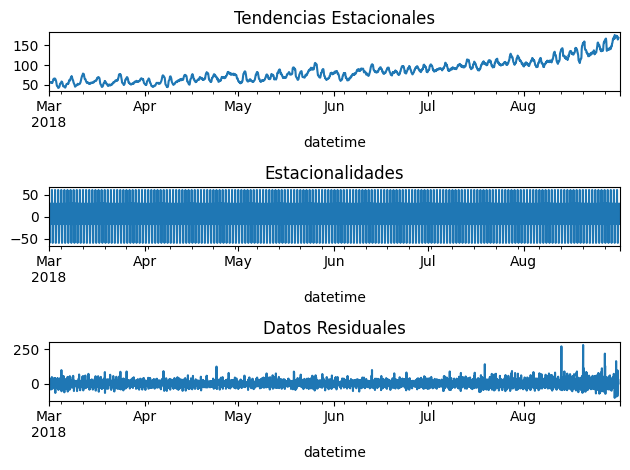

In [7]:
plt.subplot(311)
decompose_df.trend.plot(ax=plt.gca())
plt.title("Tendencias Estacionales")
plt.subplot(312)
decompose_df.seasonal.plot(ax=plt.gca())
plt.title("Estacionalidades")
plt.subplot(313)
decompose_df.resid.plot(ax=plt.gca())
plt.title("Datos Residuales")
plt.tight_layout()
plt.show()

En el primer gráfico anterior podemos observar que la tendencia para el servicio de taxis va en incremento.
Conforme pasan los meses crece la demanda por este servicio teniendo un pico en Agosto y Septiembre.
En el segundo gráfico podemos ver que fluctúa la cantidad de servicios de taxis por hora, las horas en las que no hay otro tipo de servicio disponible beneficia a los servicios de Taxis.
Horario como altas horas de la noche o madrugadas es cuando más se solicitan los viajes de taxis de este servicio.
Los residuos nos muestran información que no es atribuida a estacionalidad ni tendencia.
Aqui podemos observar información extra sobre el comportamiento del servicio, teniendo picos en donde crece nuestra tendencia.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy buen trabajo, realizaste las gráficas correctas para el análisis de datos temporales
</div>

## Formación

Ahora que tenemos un análisis de la información y una base de datos transformada a nuestras necesidades. Es tiempo de crear nuestras características para entrenar el modelo.
Ya que tengamos las características vamos a entrenar distintos modelos de regresión para pronosticar los servicios que se llevaran a cabo la siguiente hora.

In [8]:
def caracteristicas_modelo(data, max_lag, rolling_mean_size):
    df['año'] = df.index.year#Primero vamos a agregar las carcaterísticas calendario
    df['mes'] = df.index.month
    df['día'] = df.index.day
    df['día_semana'] = df.index.dayofweek
    df['hora'] = df.index.hour
    #Ahora definimos características de desfase hacemos esto para encontrar la estacionalidad de la serie
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    #Ahora calculamos la média móvil con el promedio de las series temorales que nos indican su tendencia
    df['media_móvil'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Puedes incluir más datos que puedas extraer de la serie temporal cómo la hora por ejemplo para que los modelos tengan más información de donde aprender
</div>

In [9]:
#Sacamos las características de nuestro dataframe para entrenar el modelo.
#Definimos un lag de 3 horas para tener series temporales que anlizen el comportamiento en este intervalo.
#Creamos una media movil de las últimas 5 horas para pronosticar el comportamiento cada 5 horas.
caracteristicas_modelo(df, 3, 5)
df.head(10)

,num_orders,año,mes,día,día_semana,hora,lag_1,lag_2,lag_3,media_móvil
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,NaN
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,71.0,77.8
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,54.2
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,39.6
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,28.4


In [10]:
#Ahora vamos a dividir la data en sets de entrenamiento y de prueba
#Nos aseguramos que los datos sigan un órden cronológico usando "shuffle=False"
train, test = train_test_split(df, test_size=0.1, shuffle=False)
train = train.dropna()
test = test.dropna()

In [11]:
#Creamos nuestros datasets de entrenamiento y prueba
feat_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

feat_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien, dividiste los datos en los sets necesarios para la parte de entrenamiento y pruebas
    
</div>

## Prueba

In [12]:
def rmse(valid, predict): #Definimos nuestra métrica de error
    return math.sqrt(mean_squared_error(valid, predict))

In [13]:
#Empecemos con el modelo RandomForestRegressor
for trees in range(1, 60):
    forest_model = RandomForestRegressor(n_estimators=trees, max_depth=7, max_leaf_nodes=20, random_state=12345)
    forest_model.fit(feat_train, target_train)
    forest_predict = forest_model.predict(feat_test)
    print("Cantidad de árboles:", trees)
    print()
    print("Valuación de dataset de prueba en RandomForestRegressor: ", forest_model.score(feat_test, target_test))
    print()
    print(f"RMSE RandomForestRegressor model prueba: {rmse(forest_predict, target_test)}")

Cantidad de árboles: 1

Valuación de dataset de prueba en RandomForestRegressor:  -0.002727091841222107

RMSE RandomForestRegressor model prueba: 58.62939008043759
Cantidad de árboles: 2

Valuación de dataset de prueba en RandomForestRegressor:  0.0633636288047621

RMSE RandomForestRegressor model prueba: 56.664297752743096
Cantidad de árboles: 3

Valuación de dataset de prueba en RandomForestRegressor:  0.05986603002438173

RMSE RandomForestRegressor model prueba: 56.76999741887408
Cantidad de árboles: 4

Valuación de dataset de prueba en RandomForestRegressor:  0.06185428548796035

RMSE RandomForestRegressor model prueba: 56.709935235064414
Cantidad de árboles: 5

Valuación de dataset de prueba en RandomForestRegressor:  0.05786535673460469

RMSE RandomForestRegressor model prueba: 56.83037065272166
Cantidad de árboles: 6

Valuación de dataset de prueba en RandomForestRegressor:  0.08428730616154712

RMSE RandomForestRegressor model prueba: 56.02780636698813
Cantidad de árboles: 7

V

Cantidad de árboles: 52

Valuación de dataset de prueba en RandomForestRegressor:  0.12055166600777356

RMSE RandomForestRegressor model prueba: 54.90718352400297
Cantidad de árboles: 53

Valuación de dataset de prueba en RandomForestRegressor:  0.12131345948016314

RMSE RandomForestRegressor model prueba: 54.88339759234253
Cantidad de árboles: 54

Valuación de dataset de prueba en RandomForestRegressor:  0.11988443748173327

RMSE RandomForestRegressor model prueba: 54.92800833631928
Cantidad de árboles: 55

Valuación de dataset de prueba en RandomForestRegressor:  0.12000867636615031

RMSE RandomForestRegressor model prueba: 54.92413132538126
Cantidad de árboles: 56

Valuación de dataset de prueba en RandomForestRegressor:  0.11907625455374804

RMSE RandomForestRegressor model prueba: 54.95322189590704
Cantidad de árboles: 57

Valuación de dataset de prueba en RandomForestRegressor:  0.11806060122009943

RMSE RandomForestRegressor model prueba: 54.98489168864983
Cantidad de árboles: 5

In [14]:
for depth in range(4, 10):
    forest_model = RandomForestRegressor(n_estimators=39, max_depth=depth, max_leaf_nodes=20, random_state=12345)
    forest_model.fit(feat_train, target_train)
    forest_predict = forest_model.predict(feat_test)
    print("Profundidad de árbol:", depth)
    print()
    print("Valuación de dataset de prueba en RandomForestRegressor: ", forest_model.score(feat_test, target_test))
    print()
    print(f"RMSE RandomForestRegressor model prueba: {rmse(forest_predict, target_test)}")

Profundidad de árbol: 4

Valuación de dataset de prueba en RandomForestRegressor:  0.039215236835613454

RMSE RandomForestRegressor model prueba: 57.39010975802464
Profundidad de árbol: 5

Valuación de dataset de prueba en RandomForestRegressor:  0.11770766598449967

RMSE RandomForestRegressor model prueba: 54.995892537818115
Profundidad de árbol: 6

Valuación de dataset de prueba en RandomForestRegressor:  0.12733133861865398

RMSE RandomForestRegressor model prueba: 54.69513415326901
Profundidad de árbol: 7

Valuación de dataset de prueba en RandomForestRegressor:  0.12525458620766894

RMSE RandomForestRegressor model prueba: 54.7601764531148
Profundidad de árbol: 8

Valuación de dataset de prueba en RandomForestRegressor:  0.11740756175026679

RMSE RandomForestRegressor model prueba: 55.005244935176705
Profundidad de árbol: 9

Valuación de dataset de prueba en RandomForestRegressor:  0.11740756175026679

RMSE RandomForestRegressor model prueba: 55.005244935176705


In [17]:
for leaves in range(10, 50):
    forest_model = RandomForestRegressor(n_estimators=39, max_depth=6, max_leaf_nodes=leaves, random_state=12345)
    forest_model.fit(feat_train, target_train)
    forest_predict = forest_model.predict(feat_test)
    print("Cantidad de nodos:", leaves)
    print()
    print("Valuación de dataset de prueba en RandomForestRegressor: ", forest_model.score(feat_test, target_test))
    print()
    print(f"RMSE RandomForestRegressor model prueba: {rmse(forest_predict, target_test)}")

Cantidad de nodos: 10

Valuación de dataset de prueba en RandomForestRegressor:  0.02828481002098293

RMSE RandomForestRegressor model prueba: 57.715637582214605
Cantidad de nodos: 11

Valuación de dataset de prueba en RandomForestRegressor:  0.042932146310713515

RMSE RandomForestRegressor model prueba: 57.27899197264268
Cantidad de nodos: 12

Valuación de dataset de prueba en RandomForestRegressor:  0.06032103583491932

RMSE RandomForestRegressor model prueba: 56.756257991487786
Cantidad de nodos: 13

Valuación de dataset de prueba en RandomForestRegressor:  0.0748167764212424

RMSE RandomForestRegressor model prueba: 56.31678790335994
Cantidad de nodos: 14

Valuación de dataset de prueba en RandomForestRegressor:  0.08431545764275516

RMSE RandomForestRegressor model prueba: 56.02694513732996
Cantidad de nodos: 15

Valuación de dataset de prueba en RandomForestRegressor:  0.0934244609410454

RMSE RandomForestRegressor model prueba: 55.74757753596064
Cantidad de nodos: 16

Valuación 

### Conclusiones modelo RandomForestRegressor

Este modelo por más que lo iteramos no llegamos a minimizar el error con un valor menor al objetivo deseado.
Tendríamos que usar mucho recursos para que esto suceda y no creo que sea ideal para nuestra problemática.

In [18]:
#Ahora veamos como itera el modelo LightGBM
for iteration in range (1, 70):
    light_model = LGBMRegressor(num_iterations=iteration, num_leaves=25, max_depth=10, verbose=1, metric='rmse', random_state=12345)
    light_model.fit(feat_train, target_train)
    light_predict = light_model.predict(feat_test)
    print("Número de iteraciones:", iteration)
    print()
    print("Valuación de dataset de prueba en light_model: ", light_model.score(feat_test, target_test))
    print()
    print(f"RMSE LightGBM model prueba: {rmse(light_predict, target_test)}")

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 1

Valuación de dataset de prueba en light_model:  -0.9286976151616717

RMSE LightGBM model prueba: 81.31226776541365
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 2

Valuación de dataset de prueba en light_model:  -0.7785565890793191

RMSE LightGBM 

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Valuación de dataset de prueba en light_model:  -0.06202107215064556

RMSE LightGBM model prueba: 60.33795249235701
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 13

Valuación de dataset de prueba en light_model:  -0.021288898964428205

RMSE LightGBM model prueba: 59.1695555966822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 7

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 16

Valuación de dataset de prueba en light_model:  0.07396463564078193

RMSE LightGBM model prueba: 56.34271724643038
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 17

Valuación de dataset de prueba en light_model:  0.09687256956584644

RMSE LightGBM model prueba: 55.641460162927686
[LightGBM] [Warning] Auto-cho

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 19

Valuación de dataset de prueba en light_model:  0.1563227800834036

RMSE LightGBM model prueba: 53.77893075616538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 20

Valuación de dataset de prueba en light_model:  0.17202045406001631

RMSE LightGBM model prueba: 53.276269350938804
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 21

Val

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 23

Valuación de dataset de prueba en light_model:  0.2379610442856781

RMSE LightGBM model prueba: 51.1107893713529
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 24

Valuación de dataset de prueba en light_model:  0.2527666471994614

RMSE LightGBM model prueba: 50.61183994949752
[LightGBM] [Warning] Auto-choosin

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Valuación de dataset de prueba en light_model:  0.2802177178367471

RMSE LightGBM model prueba: 49.67347898956846
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 26

Valuación de dataset de prueba en light_model:  0.2927973578982562

RMSE LightGBM model prueba: 49.237493791127235
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 27

Valuación de dataset de prueba 

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 28

Valuación de dataset de prueba en light_model:  0.3063910270854121

RMSE LightGBM model prueba: 48.761982377062395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 29

Valuación de dataset de prueba en light_model:  0.3126981404072965

RMSE LightGBM model prueba: 48.53977526636848
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 30



/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Valuación de dataset de prueba en light_model:  0.32289715157570653

RMSE LightGBM model prueba: 48.17828342493435
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 31

Valuación de dataset de prueba en light_model:  0.3262769856468061

RMSE LightGBM model prueba: 48.05788937056102
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 32



/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Valuación de dataset de prueba en light_model:  0.3297214511389963

RMSE LightGBM model prueba: 47.93488194992417
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 33

Valuación de dataset de prueba en light_model:  0.3425287589587577

RMSE LightGBM model prueba: 47.47471673913024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 34

Valuación de dataset de prueba e

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 37

Valuación de dataset de prueba en light_model:  0.3768913738765306

RMSE LightGBM model prueba: 46.217439730602585
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 38

Valuación de dataset de prueba en light_model:  0.3814239221368516

RMSE LightGBM model prueba: 46.049038020006776
[LightGBM] [Warning] Auto-choo

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 39

Valuación de dataset de prueba en light_model:  0.3872682910598846

RMSE LightGBM model prueba: 45.8309837795267
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 40

Valuación de dataset de prueba en light_model:  0.3893184634619251

RMSE LightGBM model prueba: 45.754245342331785
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 41

Valuación de dataset de prueba en light_model:  0.3891744986210307

RMSE LightGBM model prueba: 45.75963818138957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 42

Valuación de dataset de prueba en light_model:  0.3910644651580706

RMSE LightGBM model prueba: 45.68879046261281
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 43

Valuación de dataset de prueba en light_model:  0.39429070168492764

RMSE LightGBM model prueba: 45.56759651348204
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 44

Valuación de dataset de prueba en light_model:  0.3958047432245748

RMSE LightGBM model prueba: 45.51061010014326
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 45

Valuación de dataset de prueba en light_model:  0.40609261929753737

RMSE LightGBM model prueba: 45.121482783864955
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 46

Valuación de dataset de prueba en light_model:  0.4080822283603336

RMSE LightGBM model prueba: 45.045840161172606
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] S

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 47

Valuación de dataset de prueba en light_model:  0.40949216826569546

RMSE LightGBM model prueba: 44.992158892504285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 48

Valuación de dataset de prueba en light_model:  0.4178743226624634

RMSE LightGBM model prueba: 44.67168970166759
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 49

Val

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 50

Valuación de dataset de prueba en light_model:  0.4195453115390373

RMSE LightGBM model prueba: 44.607528692981994
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 51

Valuación de dataset de prueba en light_model:  0.41966769160081685

RMSE LightGBM model prueba: 44.60282603487898
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 52

Valuación de dataset de prueba en light_model:  0.4209351586997243

RMSE LightGBM model prueba: 44.55409230527286
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 53

Valuación de dataset de prueba en light_model:  0.4228835722876192

RMSE LightGBM model prueba: 44.479072256333076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 54

Valuación de dataset de prueba en light_model:  0.42256199260081795

RMSE LightGBM model prueba: 44.4914628013274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 55

Valuación de dataset de prueba en light_model:  0.43357585968814416

RMSE LightGBM model prueba: 44.06511205849782
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 56

Valuación de dataset de prueba en light_model:  0.4331040406032374

RMSE LightGBM model prueba: 44.08346088193851
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 57

Valuación de dataset de prueba en light_model:  0.4320534659884232

RMSE LightGBM model prueba: 44.12428982697594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 58

Valuación de dataset de prueba en light_model:  0.43385430739576136

RMSE LightGBM model prueba: 44.0542797714682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 59

Valuación de dataset de prueba en light_model:  0.4328023971845669

RMSE LightGBM model prueba: 44.09518765226605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 60

Valuación de dataset de prueba en light_model:  0.4392149604336216

RMSE LightGBM model prueba: 43.845215740396995
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de iteraciones: 61

Valuación de dataset de prueba en light_model:  0.4398095649356307

RMSE LightGBM model prueba: 43.82196487313111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de iteraciones: 62

Valuación de dataset de prueba en light_model:  0.4393976165539082

RMSE LightGBM model prueba: 43.8380746358101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de iteraciones: 63

Valuación de dataset de prueba en light_model:  0.44024056284264224

RMSE LightGBM model prueba: 43.80510381285677
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] 

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de iteraciones: 64

Valuación de dataset de prueba en light_model:  0.4387527350127145

RMSE LightGBM model prueba: 43.86328166358172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de iteraciones: 65

Valuación de dataset de prueba en light_model:  0.43744171664167064

RMSE LightGBM model prueba: 43.91448193571535
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de iteraciones: 66

Valuación de dataset de prueba en light_model:  0.4370583129595359

RMSE LightGBM model prueba: 43.92944403546364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number o

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de iteraciones: 67

Valuación de dataset de prueba en light_model:  0.4396954871428441

RMSE LightGBM model prueba: 43.82642662241769
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de iteraciones: 68

Valuación de dataset de prueba en light_model:  0.4377399514879775

RMSE LightGBM model prueba: 43.90283997308869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de iteraciones: 69

Valuación de dataset de prueba en light_model:  0.4364512329901393

RMSE LightGBM model prueba: 43.95312455167674


In [19]:
for leaves in range (10, 50):
    light_model = LGBMRegressor(num_iterations=60, num_leaves=leaves, max_depth=10, verbose=1, metric='rmse', random_state=12345)
    light_model.fit(feat_train, target_train)
    light_predict = light_model.predict(feat_test)
    print("Número de nodos:", leaves)
    print()
    print("Valuación de dataset de prueba en light_model: ", light_model.score(feat_test, target_test))
    print()
    print(f"RMSE LightGBM model prueba: {rmse(light_predict, target_test)}")

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 10

Valuación de dataset de prueba en light_model:  0.40611179987505375

RMSE LightGBM model prueba: 45.12075416597434
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 11

Valuación de dataset de prueba en light_model:  0.39198711604986536

RMSE LightGBM model prueba: 45.654163822305044
[LightGBM] [Warning] Auto-choosing col-wi

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 15

Valuación de dataset de prueba en light_model:  0.42190684026778624

RMSE LightGBM model prueba: 44.51669531291707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 16

Valuación de dataset de prueba en light_model:  0.43556045322521886

RMSE LightGBM model prueba: 43.987848338445595
[LightGBM] [Warning] Auto-choosing col-wi

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de nodos: 17

Valuación de dataset de prueba en light_model:  0.41556447184555834

RMSE LightGBM model prueba: 44.76022967433681
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 18

Valuación de dataset de prueba en light_model:  0.431910489724596

RMSE LightGBM model prueba: 44.12984345635134
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de nodos: 19

Valuación de dataset de prueba en light_model:  0.43697806662623595

RMSE LightGBM model prueba: 43.93257495583332
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 20

Valuación de dataset de prueba en light_model:  0.41198492167019685

RMSE LightGBM model prueba: 44.89709413380803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de nodos: 21

Valuación de dataset de prueba en light_model:  0.43691929701899457

RMSE LightGBM model prueba: 43.934867790845125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 22

Valuación de dataset de prueba en light_model:  0.4503555817998909

RMSE LightGBM model prueba: 43.40751387704431
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de nodos: 23

Valuación de dataset de prueba en light_model:  0.45569332486083136

RMSE LightGBM model prueba: 43.196228710688494
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 24

Valuación de dataset de prueba en light_model:  0.4317968081587644

RMSE LightGBM model prueba: 44.13425869256003
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de nodos: 25

Valuación de dataset de prueba en light_model:  0.4392149604336216

RMSE LightGBM model prueba: 43.845215740396995
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 26

Valuación de dataset de prueba en light_model:  0.429471925810752

RMSE LightGBM model prueba: 44.22445724913849
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de nodos: 27

Valuación de dataset de prueba en light_model:  0.43714882266953814

RMSE LightGBM model prueba: 43.925912407622356
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
Número de nodos: 28

Valuación de dataset de prueba en light_model:  0.46056560732675156

RMSE LightGBM model prueba: 43.00246172027417
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 29

Valuación de dataset de prueba en light_model:  0.40451023033272127

RMSE LightGBM model prueba: 45.18155295909425
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 30

Valuación de dataset de prueba en light_model:  0.

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 31

Valuación de dataset de prueba en light_model:  0.42845324026099785

RMSE LightGBM model prueba: 44.2639213226928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You c

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 32

Valuación de dataset de prueba en light_model:  0.41097213427340273

RMSE LightGBM model prueba: 44.93574250346356
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 35

Valuación de dataset de prueba en light_model:  0.43045936077341396

RMSE LightGBM model prueba: 44.18617018803976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Número de nodos: 36

Valuación de dataset de prueba en light_model:  0.42465635220124276

RMSE LightGBM model prueba: 44.410704549973296
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 37

Valuación de dataset de prueba en light_model:  0.4597481689625982

RMSE LightGBM model prueba: 43.03503153374195
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overh

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 38

Valuación de dataset de prueba en light_model:  0.399346398091343

RMSE LightGBM model prueba: 45.377027643899865
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Valuación de dataset de prueba en light_model:  0.4221464938953716

RMSE LightGBM model prueba: 44.507466961691335
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 41

Valuación de dataset de prueba en light_model:  0.3983625692635716

RMSE LightGBM model prueba: 45.41417464685055


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 42

Valuación de dataset de prueba en light_model:  0.40955008474701926

RMSE LightGBM model prueba: 44.98995244299876


/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 43

Valuación de dataset de prueba en light_model:  0.4291647226131853

RMSE LightGBM model prueba: 44.23636206762075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 45

Valuación de dataset de prueba en light_model:  0.450810016529241

RMSE LightGBM model prueba: 43.38956594553429
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Número de nodos: 46

Valuación de dataset de prueba en light_model:  0.4097403364425629

RMSE LightGBM model prueba: 44.98270364499135
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [20]:
for depth in range (4, 10):
    light_model = LGBMRegressor(num_iterations=60, num_leaves=45, max_depth=depth, verbose=1, metric='rmse', random_state=12345)
    light_model.fit(feat_train, target_train)
    light_predict = light_model.predict(feat_test)
    print("Profundidad máxima:", depth)
    print()
    print("Valuación de dataset de prueba en light_model: ", light_model.score(feat_test, target_test))
    print()
    print(f"RMSE LightGBM model prueba: {rmse(light_predict, target_test)}")

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Profundidad máxima: 6

Valuación de dataset de prueba en light_model:  0.44335471216214184

RMSE LightGBM model prueba: 43.683081844605674
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969,

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Profundidad máxima: 7

Valuación de dataset de prueba en light_model:  0.4317640955859898

RMSE LightGBM model prueba: 44.135529122215175
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [21]:
light_model = LGBMRegressor(num_iterations=60, num_leaves=45, max_depth=9, verbose=1, metric='rmse', random_state=12345)
light_model.fit(feat_train, target_train)
light_predict = light_model.predict(feat_test)
print()
print("Valuación de dataset de prueba en light_model: ", light_model.score(feat_test, target_test))
print()
print(f"RMSE LightGBM model prueba: {rmse(light_predict, target_test)}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Valuación de dataset de prueba en light_model:  0.449774

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### Conclusión Modelo LightGBM

Hemos iterado nuetro modelo y llegamos a la conclusión que la mejor manera de entrenarlo es la siguiente:

Fijar el número de iteraciones a 60, el máximo de nodos que sea 45 y máxima profundidad del árbol en 9.

Con esta combinación en los hiperparámetros pudimos alcanzar un error mínimo del 43.43 con el conjunto de prueba.

In [23]:
#Por último observamos como funciona el modelo CatBoost
cat_model = CatBoostRegressor(iterations=60, max_depth=7, learning_rate=0.4, loss_function='RMSE', random_state=12345)
cat_model.fit(feat_train, target_train)
cat_predict = cat_model.predict(feat_test)
print("Valuación de dataset de prueba en cat_model: ", cat_model.score(feat_test, target_test))
print()
print(f"RMSE CatBoost model prueba: {rmse(cat_predict, target_test)}")
print()

0:	learn: 32.1081976	total: 2.2ms	remaining: 130ms
1:	learn: 28.2555847	total: 3.96ms	remaining: 115ms
2:	learn: 26.2832391	total: 5.47ms	remaining: 104ms
3:	learn: 25.0724734	total: 7.02ms	remaining: 98.3ms
4:	learn: 24.1793293	total: 8.56ms	remaining: 94.2ms
5:	learn: 23.5944209	total: 10ms	remaining: 90.2ms
6:	learn: 23.2351080	total: 11.5ms	remaining: 87.2ms
7:	learn: 22.9306457	total: 12.9ms	remaining: 84.2ms
8:	learn: 22.6633001	total: 14.5ms	remaining: 82.3ms
9:	learn: 22.4973205	total: 16ms	remaining: 79.8ms
10:	learn: 22.0068204	total: 17.4ms	remaining: 77.6ms
11:	learn: 21.9672251	total: 18.9ms	remaining: 75.6ms
12:	learn: 21.7536910	total: 20.5ms	remaining: 74ms
13:	learn: 21.4333996	total: 22ms	remaining: 72.4ms
14:	learn: 21.2340231	total: 23.5ms	remaining: 70.4ms
15:	learn: 20.9778467	total: 24.9ms	remaining: 68.6ms
16:	learn: 20.7822810	total: 26.5ms	remaining: 67ms
17:	learn: 20.6414963	total: 27.9ms	remaining: 65.1ms
18:	learn: 20.5212220	total: 29.4ms	remaining: 63.5m

In [28]:
for depth in range (4, 10):
    cat_model = CatBoostRegressor(iterations=60, max_depth=depth, learning_rate=0.4, loss_function='RMSE', random_state=12345)
    cat_model.fit(feat_train, target_train)
    cat_predict = cat_model.predict(feat_test)
    print("Profundidad máxima:", depth)
    print()
    print("Valuación de dataset de prueba en cat_model: ", cat_model.score(feat_test, target_test))
    print()
    print(f"RMSE CatBoost model prueba: {rmse(cat_predict, target_test)}")
    print()

0:	learn: 33.7946670	total: 899us	remaining: 53ms
1:	learn: 31.2222648	total: 1.68ms	remaining: 48.8ms
2:	learn: 28.3893865	total: 2.32ms	remaining: 44.1ms
3:	learn: 26.6986654	total: 2.94ms	remaining: 41.2ms
4:	learn: 25.9156536	total: 3.56ms	remaining: 39.2ms
5:	learn: 25.5650418	total: 4.23ms	remaining: 38.1ms
6:	learn: 25.3295365	total: 4.83ms	remaining: 36.6ms
7:	learn: 24.8172035	total: 5.46ms	remaining: 35.5ms
8:	learn: 24.5877400	total: 6.08ms	remaining: 34.4ms
9:	learn: 24.4281783	total: 6.73ms	remaining: 33.7ms
10:	learn: 24.2740864	total: 7.32ms	remaining: 32.6ms
11:	learn: 24.1309342	total: 7.94ms	remaining: 31.8ms
12:	learn: 23.9334170	total: 8.55ms	remaining: 30.9ms
13:	learn: 23.8929038	total: 9.11ms	remaining: 29.9ms
14:	learn: 23.3930603	total: 9.71ms	remaining: 29.1ms
15:	learn: 23.1522970	total: 10.3ms	remaining: 28.3ms
16:	learn: 22.9251853	total: 10.9ms	remaining: 27.6ms
17:	learn: 22.7378663	total: 11.5ms	remaining: 26.8ms
18:	learn: 22.6998160	total: 12.1ms	remai

1:	learn: 28.2555847	total: 3.68ms	remaining: 107ms
2:	learn: 26.2832391	total: 5.34ms	remaining: 101ms
3:	learn: 25.0724734	total: 6.91ms	remaining: 96.8ms
4:	learn: 24.1793293	total: 8.46ms	remaining: 93.1ms
5:	learn: 23.5944209	total: 9.96ms	remaining: 89.6ms
6:	learn: 23.2351080	total: 11.4ms	remaining: 86.5ms
7:	learn: 22.9306457	total: 12.9ms	remaining: 83.6ms
8:	learn: 22.6633001	total: 14.4ms	remaining: 81.8ms
9:	learn: 22.4973205	total: 15.9ms	remaining: 79.4ms
10:	learn: 22.0068204	total: 17.4ms	remaining: 77.4ms
11:	learn: 21.9672251	total: 18.9ms	remaining: 75.4ms
12:	learn: 21.7536910	total: 20.4ms	remaining: 73.7ms
13:	learn: 21.4333996	total: 22ms	remaining: 72.3ms
14:	learn: 21.2340231	total: 23.5ms	remaining: 70.5ms
15:	learn: 20.9778467	total: 25ms	remaining: 68.7ms
16:	learn: 20.7822810	total: 26.5ms	remaining: 67.1ms
17:	learn: 20.6414963	total: 28ms	remaining: 65.3ms
18:	learn: 20.5212220	total: 29.5ms	remaining: 63.7ms
19:	learn: 20.2590320	total: 31ms	remaining: 

49:	learn: 14.0908013	total: 213ms	remaining: 42.6ms
50:	learn: 13.9690949	total: 217ms	remaining: 38.3ms
51:	learn: 13.9171955	total: 221ms	remaining: 34.1ms
52:	learn: 13.7426459	total: 226ms	remaining: 29.8ms
53:	learn: 13.6345056	total: 230ms	remaining: 25.5ms
54:	learn: 13.5559467	total: 234ms	remaining: 21.2ms
55:	learn: 13.4174621	total: 238ms	remaining: 17ms
56:	learn: 13.2611225	total: 242ms	remaining: 12.7ms
57:	learn: 13.1841963	total: 246ms	remaining: 8.47ms
58:	learn: 13.0642264	total: 250ms	remaining: 4.23ms
59:	learn: 12.9960456	total: 254ms	remaining: 0us
Profundidad máxima: 9

Valuación de dataset de prueba en cat_model:  0.27112373406862345

RMSE CatBoost model prueba: 49.98629019459919



In [31]:
cat_model = CatBoostRegressor(iterations=60, max_depth=4, learning_rate=0.4, loss_function='RMSE', random_state=12345)
cat_model.fit(feat_train, target_train)
cat_predict = cat_model.predict(feat_test)
print("Valuación de dataset de prueba en cat_model: ", cat_model.score(feat_test, target_test))
print()
print(f"RMSE CatBoost model prueba: {rmse(cat_predict, target_test)}")
print()

0:	learn: 33.7946670	total: 1.32ms	remaining: 77.7ms
1:	learn: 31.2222648	total: 2.15ms	remaining: 62.2ms
2:	learn: 28.3893865	total: 2.79ms	remaining: 53ms
3:	learn: 26.6986654	total: 3.41ms	remaining: 47.8ms
4:	learn: 25.9156536	total: 4.02ms	remaining: 44.3ms
5:	learn: 25.5650418	total: 4.65ms	remaining: 41.9ms
6:	learn: 25.3295365	total: 5.26ms	remaining: 39.8ms
7:	learn: 24.8172035	total: 5.92ms	remaining: 38.5ms
8:	learn: 24.5877400	total: 6.54ms	remaining: 37.1ms
9:	learn: 24.4281783	total: 7.14ms	remaining: 35.7ms
10:	learn: 24.2740864	total: 7.71ms	remaining: 34.3ms
11:	learn: 24.1309342	total: 8.29ms	remaining: 33.2ms
12:	learn: 23.9334170	total: 8.91ms	remaining: 32.2ms
13:	learn: 23.8929038	total: 9.48ms	remaining: 31.1ms
14:	learn: 23.3930603	total: 10.1ms	remaining: 30.4ms
15:	learn: 23.1522970	total: 10.7ms	remaining: 29.5ms
16:	learn: 22.9251853	total: 11.3ms	remaining: 28.7ms
17:	learn: 22.7378663	total: 11.9ms	remaining: 27.8ms
18:	learn: 22.6998160	total: 12.5ms	rema

### Conclusiones modelo CatBoost

Al iterar sobre este modelo llegamos a la conclusion que estos son los valores ideales para entrenar el modelo:

Fijar el número de iteraciones en 60, profunidad máxima por árbol en 4 y un learning rate de 0.4

Con esta combinación de valores llegamos a obtener un error mínimo de 44.52 con el conjunto de prueba.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Buen avance con el proyecto Arturo! Si, veo que no se logró bajar a menos de 48 la métrica, te recomendaría que extraigas un poco más de información de los datos temporales para esto, por ejemplo, puedes agregar la hora del día al dataset para complementar mejor la información que le pasas a los modelos.
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Excelente trabajo Arturo, se nota que vas por buen camino como Data Scientist. Este proceso de experimentación de poner o quitar características a los modelos es parte de una técnica llamada `Feature Engineering`, y es normal que te tome un poco de tiempo llegar a la combinación correcta para obtener el correcto desempeño de un modelo ya que eso es parte del proceso de experimentación.
    
Saludos!
</div>

## Conclusiones Generales

Al iterar nuestro modelos podemos observar que LightGBM y CatBoost llegan a satisfacer nuestro objetivos.
En este caso yo recomendaría utilizar el modelo CatBoost ya que alcanza el objetivo utilizando menos recursos, eficientando el tiempo computacional.
Aunque LightGBM alcanza un error menor a CatBoost, el segundo modelo itera de manera más rápìda y eficiente.
Dejaría la decisión a criterio del cliente, para que utilizen un modelo que más les acomode.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48